In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sc
import scipy

In [2]:
matplotlib.rcParams['axes.titlesize'] = '20'
matplotlib.rcParams['legend.fontsize'] = '14'
matplotlib.rcParams['axes.labelsize'] = '14'

In [3]:
# Read CCD Calibration parameters
calibration = pd.read_csv('CCD_params.csv')

c_a = calibration['params_linear'][0]
c_b = calibration['params_linear'][1]
u_c_a = calibration['cov_linear'][0]
u_c_b = calibration['cov_linear'][1]


def wave(lamb, u_lamb):
    w = lamb * c_a + c_b
    u_w = np.sqrt((lamb * u_c_a)**2 + (u_c_b)**2 + (c_a * u_lamb)**2)
    return w, u_w


w_laser = wave(calibration['laser'][0], calibration['u_laser'][0])
# print(w_laser)
# print(c_a * 9.65111944e-02)
# print(np.sqrt((c_a*5.68372354e-04)**2 + (u_c_a * 9.65111944e-02)**2))

def d_v(lamb, u_lamb):
    v = 1/w_laser[0] - 1/lamb
    u_v = np.sqrt((w_laser[1]/w_laser[0]**2)**2 + (u_lamb/lamb**2)**2)
    return v, u_v

In [4]:
def lorentz(x, A, w0, gamma, C):
    '''Function of a Lorentz-curve.

    w0 : position of maximum
    gamma : curve width
    '''
    return A/((x**2 - w0**2)**2 + gamma**2 * w0**2) + C


def voigt(x, mean, sigma, gamma, A, c):
    return A * scipy.special.voigt_profile(x-mean, sigma, gamma) + c

def gauss(x, A, mu, sigma, C):
    return A * np.exp(-(x-mu)**2 / (2*sigma**2)) + C

def doppel_gauss(x, A1, mu1, sigma1, A2, mu2, sigma2, C):
    return (A1 * np.exp(-(x-mu1)**2 / (2*sigma1**2)) + A2 * np.exp(-(x-mu2)**2 / (2*sigma2**2))) + C

def linear(x,a,b):
    return a*x+b

In [5]:
def save_params(spectrum, coefficients, covariance):
    wavelength = []
    u_wavelength = []
    dvs = []
    u_dvs = []
    for i in range(len(coefficients)):
        if coefficients[i,1] > 0:
            w = wave(coefficients[i,1], np.sqrt(covariance[i,1,1]))
            wavelength.append(w[0])
            u_wavelength.append(w[1])
        
            nu = np.array(d_v(*w)) * 1e7
            dvs.append(nu[0])
            u_dvs.append(nu[1])
        
            print('lambda = {0:3.5g} \pm {1:1.2g}'.format(w[0], w[1]))
            print('d_nu = {0:3.3g} \pm {1:1.2g}'.format(nu[0], nu[1]))
        if coefficients[i,4] > 0:
            w = wave(coefficients[i,4], np.sqrt(covariance[i,4,4]))
            wavelength.append(w[0])
            u_wavelength.append(w[1])
        
            nu = np.array(d_v(*w)) * 1e7
            dvs.append(nu[0])
            u_dvs.append(nu[1])
            print('lambda = {0:3.5g} \pm {1:1.2g}'.format(w[0], w[1]))
            print('d_nu = {0:3.3g} \pm {1:1.2g}'.format(nu[0], nu[1]))

    output_data = pd.DataFrame({#'$\\lambda\ind{CCD}$ [nm]': wavelength,
                                #'$u(\\lambda\ind{CCD})$ [nm]': u_wavelength,
                                '$d_\\nu$ [$\mathrm{cm}^{-1}$]': dvs,
                                '$u(d_\\nu)$ [$\mathrm{cm}^{-1}$]': u_dvs})

    output_data.to_csv('Calibration_Files_CCD/CCD_'+ spectrum + '.csv', index=False, sep=',')
    print('Successfully saved!')

In [6]:
file_1 = 'CCD/white_light_0degree.txt'
file_2 = 'CCD/white_light_90degree.txt'

df0 = pd.read_csv(file_1, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'],
                       decimal=',', engine='python')
df90 = pd.read_csv(file_2, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'],
                             decimal=',', engine='python')

[-8.96455315e-07  1.53950444e-03 -8.80886223e-01  1.68597534e+02] [3.01870903e-08 4.82349655e-05 2.56793225e-02 4.55497083e+00] [-0.03367384  0.03133149 -0.02915169  0.02701683]


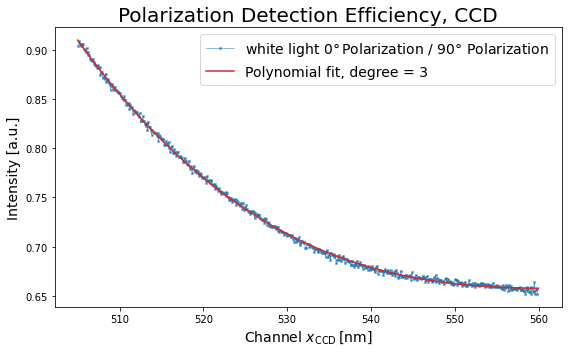

In [7]:
x_min = np.where(df0['Channel']>505)[0][0]
x_max = np.where(df0['Channel']<560)[0][-1]

x0, y0 = df0['Channel'][x_min:x_max], df0['Counts'][x_min:x_max]
x90, y90 = df90['Channel'][x_min:x_max], df90['Counts'][x_min:x_max]

lin_par, lin_cov = np.polyfit(x0, y0/y90, 3, rcond=None, full=False, w=None, cov=True)

print(lin_par, np.sqrt(np.diagonal(lin_cov)), np.sqrt(np.diagonal(lin_cov)) / lin_par)

xaxis = np.linspace(505, 560, 1001)

fig, ax = plt.subplots(figsize = (8,5))
# ax.plot(x0, y0, marker = 'x', lw=0.5, ms = 2, label = r'white light $0\degree$ Polarization filter', color = 'C0')
# ax.plot(x0, y0, marker = 'x', lw=0.5, ms = 2, label= r'white light $90\degree$ Polarization filter', color = 'C1')
ax.plot(x0, y0/y90, marker = 'x', lw=0.5, ms = 2, label= r'white light $0\degree\,$Polarization / $90\degree$ Polarization', color = 'C0')
ax.plot(xaxis, np.polyval(lin_par, xaxis), color = 'C3', label ='Polynomial fit, degree = 3')
ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_title(r'Polarization Detection Efficiency, CCD')
ax.legend()
plt.tight_layout()
# plt.savefig('Figures/Notchfilter.pdf', dpi=800)
plt.show()

**CCl4 Spectrum**

In [8]:
file_CCl4 = 'CCD/CCl4_spectrum_2.txt'
df_CCl4 = pd.read_csv(file_CCl4, skiprows=17, skipfooter=1, sep='\t',
                      names=['Channel', 'Counts'], decimal=',', engine='python')

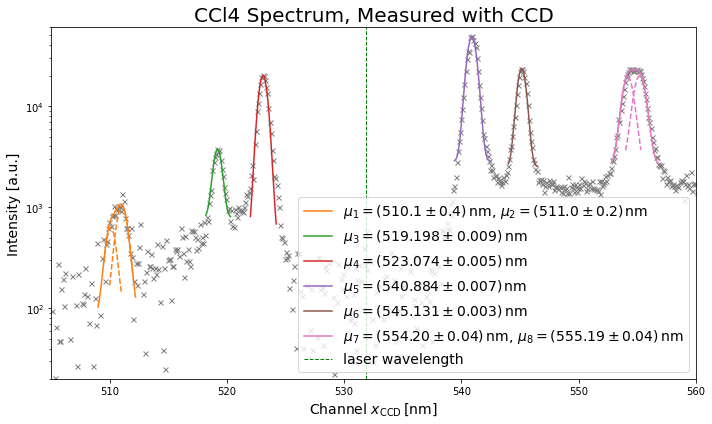

In [9]:
fig, ax = plt.subplots(figsize = (10,6))
y_counts = df_CCl4['Counts'] # - df_back['Counts']
ax.plot(df_CCl4['Channel'], y_counts, marker = 'x', lw=0, ms = 5, color = 'grey')
coefficients = np.zeros((6, 7))
covariance = np.zeros((6, 7, 7))

a = [[820, 849], [910, 930], [950, 965], [1125, 1155], [1179, 1200], [1270, 1320]]
p0s = [[1000, 510.5, 1, 1000, 511.5, 1, 0], [5000, 519, 1, 0], [30000, 525, 1, 0],
       [60000, 541, 1, 0], [20000, 545, 1, 0], [20000, 554.3, 1, 20000, 555.3, 1, 0]]
xaxis = [np.linspace(509, 512.2, 1001), np.linspace(518.2, 520.3, 1001), np.linspace(522, 524.2, 1001),
         np.linspace(539.4, 542.5, 1001), np.linspace(544,546.5,1001), np.linspace(552.8, 556.8, 1001)]
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

i = 0
params, cov = sc.curve_fit(doppel_gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                  p0 = p0s[i])
# ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
# ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_1 = ({:.1f} \pm {:.1f})\,$nm, $\mu_2 = ({:.1f} \pm {:.1f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
x = np.linspace(509.5,511,1001)
ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
x = np.linspace(510,512,1001)
ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
coefficients[i] = params
covariance[i] = cov

for i in range(1,5):
    function = gauss
    params, cov = sc.curve_fit(function, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                              p0 = p0s[i])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    # print(params, np.sqrt(np.diag(cov)))
    # ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
    # ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], function(xaxis[i], *params), color=colors[i], label = r'$\mu_{} = ({:.3f} \pm {:.3f})\,$nm'.format(i+2, params[1], np.sqrt(cov[1,1])))

i = 5
params, cov = sc.curve_fit(doppel_gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                  p0 = p0s[i])
# ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
# ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_7 = ({:.2f} \pm {:.2f})\,$nm, $\mu_8 = ({:.2f} \pm {:.2f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
coefficients[i] = params
covariance[i] = cov

x = np.linspace(553,555.3,1001)
ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[5])
x = np.linspace(554,556,1001)
ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[5])

ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_title(r'CCl4 Spectrum, Measured with CCD')
ax.axvline(531.8180, ls='--', color = 'green', label=r'laser wavelength', lw=1)
ax.legend()
ax.set_xlim([505, 560])
# ax.set_xlim([542, 550])  # second peak
# ax.set_xlim([575, 580])
ax.set_yscale('log')
ax.set_ylim([20, 60000])
plt.tight_layout()
plt.savefig('FiguresCCD/CCl4_Spectrum.pdf', dpi=800)
plt.show()

In [10]:
spectrum = 'CCl4'
save_params(spectrum, coefficients, covariance)

lambda = 510.42 \pm 0.39
d_nu = -799 \pm 16
lambda = 511.36 \pm 0.3
d_nu = -763 \pm 13
lambda = 519.51 \pm 0.17
d_nu = -456 \pm 8.7
lambda = 523.38 \pm 0.17
d_nu = -314 \pm 8.7
lambda = 541.17 \pm 0.17
d_nu = 314 \pm 8.4
lambda = 545.41 \pm 0.17
d_nu = 458 \pm 8.4
lambda = 554.47 \pm 0.18
d_nu = 758 \pm 8.4
lambda = 555.46 \pm 0.18
d_nu = 790 \pm 8.4
Successfully saved!


**CCl4 with lamb**

In [11]:
file_CCl4 = 'CCD/CCl4_spectrum_lamb_1.txt'
df_CCl4 = pd.read_csv(file_CCl4, skiprows=17, skipfooter=1, sep='\t',
                      names=['Channel', 'Counts'], decimal=',', engine='python')

[1.23937316e+04 5.19147756e+02 3.76791092e-01 1.44235632e+03] [1.95937715e+02 4.32729140e-03 8.62106115e-03 1.95433517e+02]
[1.46244417e+04 5.23074024e+02 3.59908500e-01 1.67615661e+03] [3.47734530e+02 3.92380020e-03 1.04110918e-02 3.72518982e+02]
[3.81728351e+04 5.40887352e+02 3.91543981e-01 3.50815023e+03] [6.70604935e+02 6.96512729e-03 9.43600764e-03 4.47538541e+02]
[5.55930375e+04 5.45097952e+02 5.27467896e-01 2.81165224e+03] [1.24912819e+03 1.19188863e-02 1.62847210e-02 8.50596526e+02]


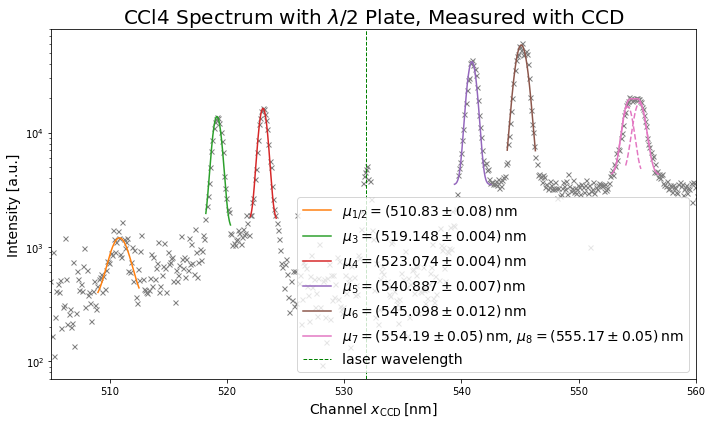

In [12]:
fig, ax = plt.subplots(figsize = (10,6))
y_counts = df_CCl4['Counts'] # - df_back['Counts']
ax.plot(df_CCl4['Channel'], y_counts, marker = 'x', lw=0, ms = 5, color = 'grey')
coefficients = np.zeros((6, 7))
covariance = np.zeros((6, 7, 7))

a = [[820, 852], [910, 930], [950, 965], [1125, 1155], [1170, 1210], [1270, 1320]]
p0s = [[1000, 510.1, 1, 0], [5000, 519, 1, 0], [30000, 525, 1, 0],
       [60000, 541, 1, 0], [20000, 545, 1, 0], [20000, 554.3, 1, 20000, 555.3, 1, 0]]
xaxis = [np.linspace(509, 512.5, 1001), np.linspace(518.2, 520.3, 1001), np.linspace(522, 524.2, 1001),
         np.linspace(539.4, 542.5, 1001), np.linspace(543.9,546.3,1001), np.linspace(552.8, 556.8, 1001)]
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

vlines = False

fit1=True
# It is only possible to fit one gauss, no double line
if fit1:
    i = 0
    params, cov = sc.curve_fit(gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_{{1/2}} = ({:.2f} \pm {:.2f})\,$nm'.format(params[1], np.sqrt(cov[1,1])))
    #x = np.linspace(509.5,511,1001)
    #ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    #x = np.linspace(510,512,1001)
    #ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov

for i in range(1,5):
    function = gauss
    params, cov = sc.curve_fit(function, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                              p0 = p0s[i])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    print(params, np.sqrt(np.diag(cov)))
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], function(xaxis[i], *params), color=colors[i], label = r'$\mu_{} = ({:.3f} \pm {:.3f})\,$nm'.format(i+2, params[1], np.sqrt(cov[1,1])))

fit5=True
if fit5:
    i = 5
    params, cov = sc.curve_fit(doppel_gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_7 = ({:.2f} \pm {:.2f})\,$nm, $\mu_8 = ({:.2f} \pm {:.2f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    coefficients[i] = params
    covariance[i] = cov

    x = np.linspace(553,555.3,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[5])
    x = np.linspace(554,556,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[5])

ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_title(r'CCl4 Spectrum with $\lambda/2$ Plate, Measured with CCD')
ax.axvline(531.8180, ls='--', color = 'green', label=r'laser wavelength', lw=1)
ax.legend()
ax.set_xlim([505, 560])
# ax.set_xlim([542, 550])  # second peak
# ax.set_xlim([575, 580])
ax.set_yscale('log')
ax.set_ylim([70, 80000])
plt.tight_layout()
plt.savefig('FiguresCCD/CCl4_Spectrum_lamb.pdf', dpi=800)
plt.show()

In [13]:
spectrum = 'CCl4_lamb'
save_params(spectrum, coefficients, covariance)

lambda = 511.16 \pm 0.19
d_nu = -771 \pm 9.3
lambda = 519.46 \pm 0.17
d_nu = -458 \pm 8.7
lambda = 523.38 \pm 0.17
d_nu = -314 \pm 8.7
lambda = 541.17 \pm 0.17
d_nu = 315 \pm 8.4
lambda = 545.38 \pm 0.17
d_nu = 457 \pm 8.4
lambda = 554.46 \pm 0.18
d_nu = 757 \pm 8.4
lambda = 555.44 \pm 0.18
d_nu = 789 \pm 8.5
Successfully saved!


**CCl4 0 degree**

In [14]:
file_CCl4 = 'CCD/CCl4_spectrum_0deg.txt'
df_CCl4 = pd.read_csv(file_CCl4, skiprows=17, skipfooter=1, sep='\t',
                      names=['Channel', 'Counts'], decimal=',', engine='python')

[7.02114303e+02 5.19221353e+02 3.90072078e-01 2.06330508e+02] [9.90767021e+01 3.64540370e-02 7.90005364e-02 1.02648159e+02]
[3.66814123e+03 5.23082425e+02 3.79217090e-01 2.22517143e+02] [1.62926179e+02 6.86765210e-03 1.96398376e-02 1.75281480e+02]
[9.14395557e+03 5.40878571e+02 3.86167397e-01 6.26663957e+02] [1.24269983e+02 5.34336259e-03 7.18054890e-03 8.16440464e+01]
[ 4.68730948e+03  5.45135300e+02 -3.72129101e-01  6.05284656e+02] [1.06218911e+02 6.89114662e-03 1.15678105e-02 9.50672716e+01]


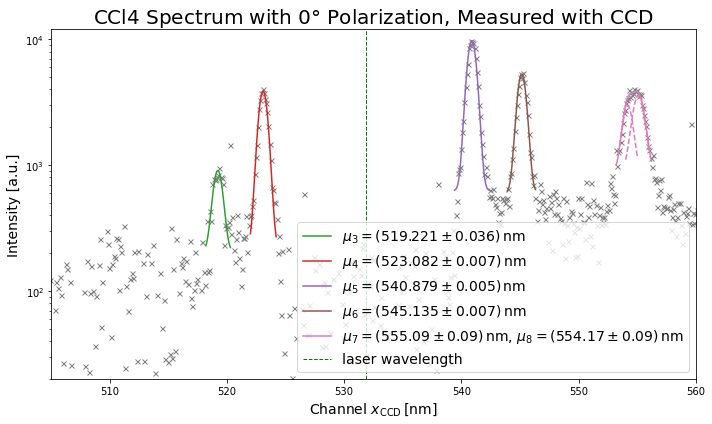

In [16]:
I_0 = np.zeros((6,4))

fig, ax = plt.subplots(figsize = (10,6))
y_counts = df_CCl4['Counts'] # - df_back['Counts']
ax.plot(df_CCl4['Channel'], y_counts, marker = 'x', lw=0, ms = 5, color = 'grey')
coefficients = np.zeros((6, 7))
covariance = np.zeros((6, 7, 7))

a = [[819, 853], [910, 930], [950, 965], [1125, 1155], [1179, 1200], [1273, 1310]]
p0s = [[300, 510.1, 1, 0], [5000, 519, 1, 0], [30000, 525, 1, 0],
       [60000, 541, 1, 0], [20000, 545, 1, 0], [20000, 554.2, 1, 20000, 555.5, 1, 0]]
xaxis = [np.linspace(509, 512.5, 1001), np.linspace(518.2, 520.3, 1001), np.linspace(522, 524.2, 1001),
         np.linspace(539.4, 542.5, 1001), np.linspace(543.9,546.3,1001), np.linspace(553.2, 556.2, 1001)]
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

vlines = 0

fit1=False
fit1_doppel=False
# It is only possible to fit one gauss, no double line
if fit1:
    i = 0
    params, cov = sc.curve_fit(gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_{{1/2}} = ({:.1f} \pm {:.1f})\,$nm'.format(params[1], np.sqrt(cov[1,1])))
    #x = np.linspace(509.5,511,1001)
    #ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    #x = np.linspace(510,512,1001)
    #ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    
if fit1_doppel:
    i = 0
    params, cov = sc.curve_fit(doppel_gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = [1000, 510.5, 1, 1000, 511.2, 1, 0])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_1 = ({:.1f} \pm {:.1f})\,$nm, $\mu_2 = ({:.1f} \pm {:.1f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    x = np.linspace(509.5,511,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    x = np.linspace(510,512,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i] = params
    covariance[i] = cov

for i in range(1,5):
    function = gauss
    params, cov = sc.curve_fit(function, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                              p0 = p0s[i])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    print(params, np.sqrt(np.diag(cov)))
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], function(xaxis[i], *params), color=colors[i], label = r'$\mu_{} = ({:.3f} \pm {:.3f})\,$nm'.format(i+2, params[1], np.sqrt(cov[1,1])))

i=5
#ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
#ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
fit5=True
if fit5:
    i = 5
    params, cov = sc.curve_fit(doppel_gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_7 = ({:.2f} \pm {:.2f})\,$nm, $\mu_8 = ({:.2f} \pm {:.2f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    coefficients[i] = params
    covariance[i] = cov

    x = np.linspace(554,556,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[5])
    x = np.linspace(553.5,555,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[5])

ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_title(r'CCl4 Spectrum with $0\degree$ Polarization, Measured with CCD')
ax.axvline(531.8180, ls='--', color = 'green', label=r'laser wavelength', lw=1)
ax.legend()
ax.set_xlim([505, 560])
# ax.set_xlim([542, 550])  # second peak
# ax.set_xlim([500, 520])
ax.set_yscale('log')
ax.set_ylim([20, 12000])
plt.tight_layout()
plt.savefig('FiguresCCD/CCl4_Spectrum_0deg.pdf', dpi=800)
plt.show()
I_0[:5,0], I_0[:5,2] = coefficients[1:,0], coefficients[1:,1]
I_0[:5,1], I_0[:5,3] = np.sqrt(covariance[1:,0,0]), np.sqrt(covariance[1:,1,1])
I_0[5,0], I_0[5,2] = coefficients[5,3], coefficients[5,4]
I_0[5,1], I_0[5,3] = np.sqrt(covariance[5,3,3]), np.sqrt(covariance[5,4,4])

In [17]:
spectrum = 'CCl4_0deg'
save_params(spectrum, coefficients, covariance)

lambda = 519.53 \pm 0.17
d_nu = -455 \pm 8.8
lambda = 523.39 \pm 0.17
d_nu = -313 \pm 8.7
lambda = 541.16 \pm 0.17
d_nu = 314 \pm 8.4
lambda = 545.42 \pm 0.17
d_nu = 458 \pm 8.4
lambda = 555.36 \pm 0.19
d_nu = 786 \pm 8.7
lambda = 554.44 \pm 0.19
d_nu = 757 \pm 8.8
Successfully saved!


**CCl4 lamb 0 deg**

In [18]:
file_CCl4 = 'CCD/CCl4_spectrum_lamb_0deg.txt'
df_CCl4 = pd.read_csv(file_CCl4, skiprows=17, skipfooter=1, sep='\t',
                      names=['Channel', 'Counts'], decimal=',', engine='python')

[1.11413183e+03 5.19160879e+02 4.36025452e-01 5.47309957e+02] [2.55061906e+02 7.72745702e-02 1.46334411e-01 2.47031829e+02]
[2.37445778e+03 5.23050015e+02 4.13603310e-01 5.20414144e+02] [1.88799658e+02 2.60582986e-02 4.77343982e-02 1.79331029e+02]
[6.22514028e+03 5.40876668e+02 3.95760754e-01 9.11589509e+02] [1.92842403e+02 1.23583595e-02 1.68841467e-02 1.30554867e+02]
[ 7.78486589e+03  5.45121561e+02 -3.54896439e-01  1.11951345e+03] [2.38776130e+02 1.19271042e-02 1.38148288e-02 1.07031032e+02]


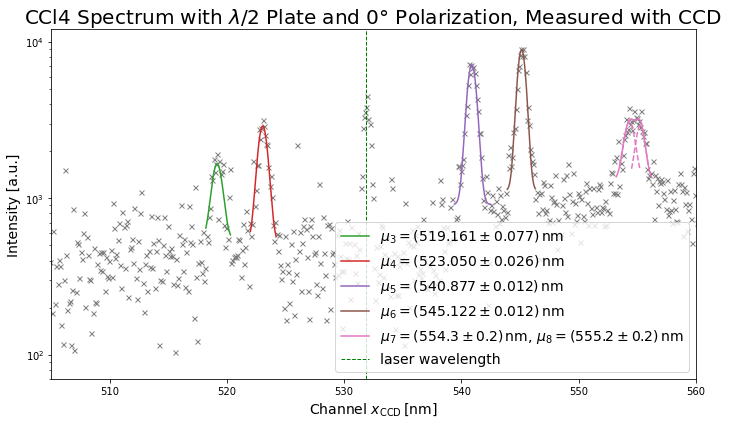

In [19]:
I_lamb0 = np.zeros((6,4))
fig, ax = plt.subplots(figsize = (10,6))
y_counts = df_CCl4['Counts'] # - df_back['Counts']
ax.plot(df_CCl4['Channel'], y_counts, marker = 'x', lw=0, ms = 5, color = 'grey')
coefficients = np.zeros((6, 7))
covariance = np.zeros((6, 7, 7))

a = [[819, 853], [908, 932], [946, 969], [1125, 1155], [1170, 1210], [1273, 1310]]
p0s = [[300, 510.1, 1, 0], [5000, 519, 1, 0], [30000, 525, 1, 0],
       [60000, 541, 1, 0], [20000, 545, 1, 0], [20000, 554.2, 1, 20000, 555.5, 1, 0]]
xaxis = [np.linspace(509, 512.5, 1001), np.linspace(518.2, 520.3, 1001), np.linspace(522, 524.2, 1001),
         np.linspace(539.4, 542.5, 1001), np.linspace(543.9,546.3,1001), np.linspace(553.2, 556.2, 1001)]
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

vlines = False

fit1=False
fit1_doppel=False
# It is only possible to fit one gauss, no double line
if fit1:
    i = 0
    params, cov = sc.curve_fit(gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_{{1/2}} = ({:.1f} \pm {:.1f})\,$nm'.format(params[1], np.sqrt(cov[1,1])))
    #x = np.linspace(509.5,511,1001)
    #ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    #x = np.linspace(510,512,1001)
    #ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    
if fit1_doppel:
    i = 0
    params, cov = sc.curve_fit(doppel_gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = [1000, 510.5, 1, 1000, 511.2, 1, 0])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_1 = ({:.1f} \pm {:.1f})\,$nm, $\mu_2 = ({:.1f} \pm {:.1f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    x = np.linspace(509.5,511,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    x = np.linspace(510,512,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i] = params
    covariance[i] = cov

for i in range(1,5):
    function = gauss
    params, cov = sc.curve_fit(function, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                              p0 = p0s[i])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    print(params, np.sqrt(np.diag(cov)))
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], function(xaxis[i], *params), color=colors[i], label = r'$\mu_{} = ({:.3f} \pm {:.3f})\,$nm'.format(i+2, params[1], np.sqrt(cov[1,1])))


fit5=True
if fit5:
    i = 5
    params, cov = sc.curve_fit(doppel_gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_7 = ({:.1f} \pm {:.1f})\,$nm, $\mu_8 = ({:.1f} \pm {:.1f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    coefficients[i] = params
    covariance[i] = cov

    x = np.linspace(553.5,555.2,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[5])
    x = np.linspace(554.5,556,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[5])

ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_title(r'CCl4 Spectrum with $\lambda/2$ Plate and $0\degree$ Polarization, Measured with CCD')
ax.axvline(531.8180, ls='--', color = 'green', label=r'laser wavelength', lw=1)
ax.legend()
ax.set_xlim([505, 560])
# ax.set_xlim([542, 550])  # second peak
# ax.set_xlim([550, 560])
ax.set_yscale('log')
ax.set_ylim([70, 12000])
plt.tight_layout()
plt.savefig('FiguresCCD/CCl4_Spectrum_lamb_0deg.pdf', dpi=800)
plt.show()

I_lamb0[:5,0], I_lamb0[:5,2] = coefficients[1:,0], coefficients[1:,1]
I_lamb0[:5,1], I_lamb0[:5,3] = np.sqrt(covariance[1:,0,0]), np.sqrt(covariance[1:,1,1])
I_lamb0[5,0], I_lamb0[5,2] = coefficients[5,3], coefficients[5,4]
I_lamb0[5,1], I_lamb0[5,3] = np.sqrt(covariance[5,3,3]), np.sqrt(covariance[5,4,4])

In [20]:
spectrum = 'CCl4_lamb_0deg'
save_params(spectrum, coefficients, covariance)

lambda = 519.47 \pm 0.19
d_nu = -457 \pm 9.2
lambda = 523.36 \pm 0.17
d_nu = -314 \pm 8.7
lambda = 541.16 \pm 0.17
d_nu = 314 \pm 8.5
lambda = 545.4 \pm 0.17
d_nu = 458 \pm 8.4
lambda = 554.59 \pm 0.28
d_nu = 762 \pm 11
lambda = 555.51 \pm 0.26
d_nu = 791 \pm 10
Successfully saved!


**CCl4 90 deg**

In [21]:
file_CCl4 = 'CCD/CCl4_spectrum_90deg.txt'
df_CCl4 = pd.read_csv(file_CCl4, skiprows=17, skipfooter=1, sep='\t',
                      names=['Channel', 'Counts'], decimal=',', engine='python')

[175.25402732 510.522757     0.81584091  37.79716758] [42.31065594  0.18055123  0.28648883 35.14891242]
[9.87690871e+02 5.19203351e+02 3.94546693e-01 2.35958075e+02] [8.33850690e+01 2.14343286e-02 4.75090906e-02 8.70868232e+01]
[5.22650724e+03 5.23085523e+02 3.67753940e-01 3.11318964e+02] [1.92516120e+02 6.10259845e-03 1.62995914e-02 2.06203610e+02]
[1.42111060e+04 5.40888728e+02 3.83684203e-01 9.22832598e+02] [1.77647485e+02 4.89524191e-03 6.54521932e-03 1.15689401e+02]
[7.75756954e+03 5.45138892e+02 3.74188564e-01 8.54850447e+02] [1.13871991e+02 4.44787195e-03 7.53801362e-03 1.02721721e+02]
[4.15665769e+03 5.54182216e+02 4.27043395e-01 5.04764674e+03
 5.55133091e+02 5.03714317e-01 1.13666252e+03] [5.67259230e+02 6.57532168e-02 4.47559296e-02 4.26469730e+02
 7.10608354e-02 5.03599186e-02 4.34791550e+02]


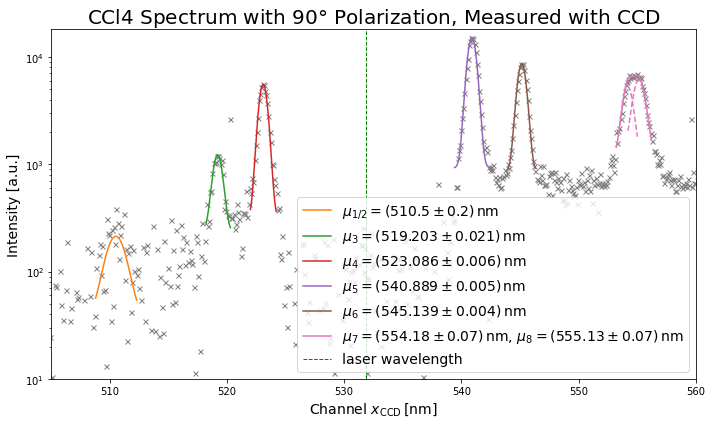

In [23]:
I_90 = np.zeros((6,4))
fig, ax = plt.subplots(figsize = (10,6))
y_counts = df_CCl4['Counts'] # - df_back['Counts']
ax.plot(df_CCl4['Channel'], y_counts, marker = 'x', lw=0, ms = 5, color = 'grey')
coefficients = np.zeros((6, 7))
covariance = np.zeros((6, 7, 7))

a = [[810, 860], [910, 930], [950, 965], [1125, 1155], [1179, 1200], [1276, 1304]]
p0s = [[400, 510.5, 1, 0], [5000, 519, 1, 0], [30000, 525, 1, 0],
       [60000, 541, 1, 0], [20000, 545, 1, 0], [20000, 554.2, 1, 20000, 555.5, 1, 0]]
xaxis = [np.linspace(508.8, 512.3, 1001), np.linspace(518.2, 520.3, 1001), np.linspace(522, 524.2, 1001),
         np.linspace(539.4, 542.5, 1001), np.linspace(543.9,546.3,1001), np.linspace(553.2, 556.2, 1001)]
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

vlines = False

fit1=True
fit1_doppel=False
# It is only possible to fit one gauss, no double line
if fit1:
    i = 0
    params, cov = sc.curve_fit(gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_{{1/2}} = ({:.1f} \pm {:.1f})\,$nm'.format(params[1], np.sqrt(cov[1,1])))
    #x = np.linspace(509.5,511,1001)
    #ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    #x = np.linspace(510,512,1001)
    #ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    print(params, np.sqrt(np.diag(cov)))
    
if fit1_doppel:
    i = 0
    params, cov = sc.curve_fit(doppel_gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = [1000, 510.5, 1, 1000, 511.2, 1, 0])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_1 = ({:.1f} \pm {:.1f})\,$nm, $\mu_2 = ({:.1f} \pm {:.1f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    x = np.linspace(509.5,511,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    x = np.linspace(510,512,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i] = params
    covariance[i] = cov

for i in range(1,5):
    function = gauss
    params, cov = sc.curve_fit(function, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                              p0 = p0s[i])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    print(params, np.sqrt(np.diag(cov)))
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], function(xaxis[i], *params), color=colors[i], label = r'$\mu_{} = ({:.3f} \pm {:.3f})\,$nm'.format(i+2, params[1], np.sqrt(cov[1,1])))

i=5
#ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
#ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
fit5=True
if fit5:
    i = 5
    params, cov = sc.curve_fit(doppel_gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_7 = ({:.2f} \pm {:.2f})\,$nm, $\mu_8 = ({:.2f} \pm {:.2f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    coefficients[i] = params
    covariance[i] = cov

    x = np.linspace(553.5,555,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[5])
    x = np.linspace(554.2,556,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[5])
    print(params, np.sqrt(np.diag(cov)))

ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_title(r'CCl4 Spectrum with $90\degree$ Polarization, Measured with CCD')
ax.axvline(531.8180, ls='--', color = 'green', label=r'laser wavelength', lw=1)
ax.legend()
ax.set_xlim([505, 560])
# ax.set_xlim([542, 550])  # second peak
# ax.set_xlim([500, 520])
ax.set_yscale('log')
ax.set_ylim([10, 18000])
plt.tight_layout()
plt.savefig('FiguresCCD/CCl4_Spectrum_90deg.pdf', dpi=800)
plt.show()

I_90[:5,0], I_90[:5,2] = coefficients[1:,0], coefficients[1:,1]
I_90[:5,1], I_90[:5,3] = np.sqrt(covariance[1:,0,0]), np.sqrt(covariance[1:,1,1])
I_90[5,0], I_90[5,2] = coefficients[5,3], coefficients[5,4]
I_90[5,1], I_90[5,3] = np.sqrt(covariance[5,3,3]), np.sqrt(covariance[5,4,4])

In [24]:
spectrum = 'CCl4_90deg'
save_params(spectrum, coefficients, covariance)

lambda = 510.85 \pm 0.25
d_nu = -782 \pm 11
lambda = 519.52 \pm 0.17
d_nu = -456 \pm 8.7
lambda = 523.39 \pm 0.17
d_nu = -313 \pm 8.7
lambda = 541.17 \pm 0.17
d_nu = 315 \pm 8.4
lambda = 545.42 \pm 0.17
d_nu = 458 \pm 8.4
lambda = 554.45 \pm 0.19
d_nu = 757 \pm 8.6
lambda = 555.4 \pm 0.19
d_nu = 788 \pm 8.6
Successfully saved!


**CCl4 lamb 90 deg**

In [25]:
file_CCl4 = 'CCD/CCl4_spectrum_lamb_90deg.txt'
df_CCl4 = pd.read_csv(file_CCl4, skiprows=17, skipfooter=1, sep='\t',
                      names=['Channel', 'Counts'], decimal=',', engine='python')

[3.55324377e+03 5.19175279e+02 3.50175206e-01 6.76622083e+02] [2.92633158e+02 2.83380638e-02 4.08230828e-02 2.14194110e+02]
[3.70457644e+03 5.23095926e+02 3.59667765e-01 3.89837237e+02] [6.02652953e+01 5.48314943e-03 8.34156354e-03 4.78868006e+01]
[1.06057219e+04 5.40897352e+02 3.87582556e-01 8.14627598e+02] [1.67767256e+02 6.23356861e-03 8.38047007e-03 1.10472401e+02]
[3.07160826e+04 5.45117360e+02 4.00079918e-01 1.30740694e+03] [1.95450598e+02 2.75155048e-03 3.29739863e-03 9.81977976e+01]


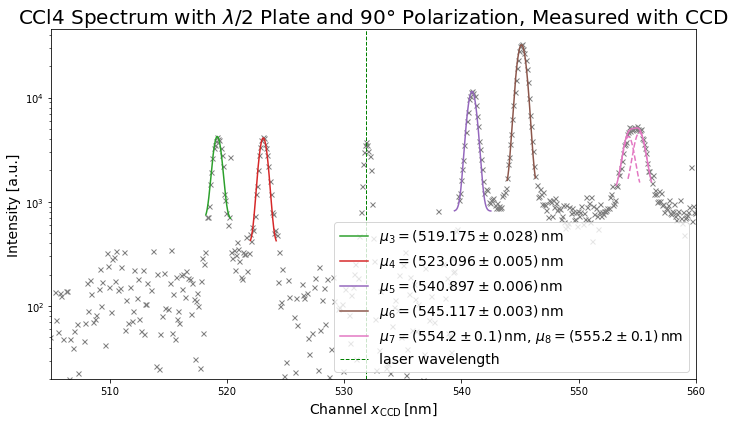

In [26]:
I_lamb90 = np.zeros((6,4))
fig, ax = plt.subplots(figsize = (10,6))
y_counts = df_CCl4['Counts'] # - df_back['Counts']
ax.plot(df_CCl4['Channel'], y_counts, marker = 'x', lw=0, ms = 5, color = 'grey')
coefficients = np.zeros((6, 7))
covariance = np.zeros((6, 7, 7))

a = [[810, 860], [908, 932], [946, 969], [1125, 1155], [1170, 1210], [1273, 1305]]
p0s = [[400, 510.1, 1, 0], [5000, 519, 1, 0], [30000, 525, 1, 0],
       [60000, 541, 1, 0], [20000, 545, 1, 0], [20000, 554.2, 1, 20000, 555.5, 1, 0]]
xaxis = [np.linspace(509, 512.5, 1001), np.linspace(518.2, 520.3, 1001), np.linspace(522, 524.2, 1001),
         np.linspace(539.4, 542.5, 1001), np.linspace(543.9,546.3,1001), np.linspace(553.2, 556.2, 1001)]
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

vlines = False

fit1=False
fit1_doppel=False
# It is only possible to fit one gauss, no double line
if fit1:
    i = 0
    params, cov = sc.curve_fit(gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_{{1/2}} = ({:.1f} \pm {:.1f})\,$nm'.format(params[1], np.sqrt(cov[1,1])))
    #x = np.linspace(509.5,511,1001)
    #ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    #x = np.linspace(510,512,1001)
    #ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    
if fit1_doppel:
    i = 0
    params, cov = sc.curve_fit(doppel_gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = [1000, 510.5, 1, 1000, 511.2, 1, 0])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_1 = ({:.1f} \pm {:.1f})\,$nm, $\mu_2 = ({:.1f} \pm {:.1f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    x = np.linspace(509.5,511,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    x = np.linspace(510,512,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i] = params
    covariance[i] = cov

for i in range(1,5):
    function = gauss
    params, cov = sc.curve_fit(function, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                              p0 = p0s[i])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    print(params, np.sqrt(np.diag(cov)))
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], function(xaxis[i], *params), color=colors[i], label = r'$\mu_{} = ({:.3f} \pm {:.3f})\,$nm'.format(i+2, params[1], np.sqrt(cov[1,1])))


fit5=True
if fit5:
    i = 5
    params, cov = sc.curve_fit(doppel_gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_7 = ({:.1f} \pm {:.1f})\,$nm, $\mu_8 = ({:.1f} \pm {:.1f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    coefficients[i] = params
    covariance[i] = cov

    x = np.linspace(553.5,555.2,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[5])
    x = np.linspace(554.2,556,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[5])

ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_title(r'CCl4 Spectrum with $\lambda/2$ Plate and $90\degree$ Polarization, Measured with CCD')
ax.axvline(531.8180, ls='--', color = 'green', label=r'laser wavelength', lw=1)
ax.legend()
ax.set_xlim([505, 560])
# ax.set_xlim([542, 550])  # second peak
# ax.set_xlim([550, 560])
ax.set_yscale('log')
ax.set_ylim([20, 45000])
plt.tight_layout()
plt.savefig('FiguresCCD/CCl4_Spectrum_lamb_90deg.pdf', dpi=800)
plt.show()

I_lamb90[:5,0], I_lamb90[:5,2] = coefficients[1:,0], coefficients[1:,1]
I_lamb90[:5,1], I_lamb90[:5,3] = np.sqrt(covariance[1:,0,0]), np.sqrt(covariance[1:,1,1])
I_lamb90[5,0], I_lamb90[5,2] = coefficients[5,3], coefficients[5,4]
I_lamb90[5,1], I_lamb90[5,3] = np.sqrt(covariance[5,3,3]), np.sqrt(covariance[5,4,4])

In [27]:
spectrum = 'CCl4_lamb_90deg'
save_params(spectrum, coefficients, covariance)

lambda = 519.49 \pm 0.17
d_nu = -457 \pm 8.8
lambda = 523.4 \pm 0.17
d_nu = -313 \pm 8.7
lambda = 541.18 \pm 0.17
d_nu = 315 \pm 8.4
lambda = 545.4 \pm 0.17
d_nu = 458 \pm 8.4
lambda = 554.51 \pm 0.2
d_nu = 759 \pm 8.9
lambda = 555.44 \pm 0.2
d_nu = 789 \pm 9
Successfully saved!


**Depolarization determination**

In [28]:
print(lin_par)

[-8.96455315e-07  1.53950444e-03 -8.80886223e-01  1.68597534e+02]


In [29]:
def u_corr(x, ux):
    dy = np.zeros(5)

    dy[0] = x**3
    dy[1] = x**2
    dy[2] = x
    dy[3] = 1
    dy[4] = 3*lin_par[0]*x**2 + 2*lin_par[1]*x + lin_par[2]

    cov = np.zeros((5,5))
    cov[0:4, 0:4] = lin_cov
    cov[4, 4] = ux**2

    u_corr_facs = np.sqrt(dy @ cov @ dy)
    return u_corr_facs

In [30]:
def depol(I0, I90):
    x = (I0[:,2]+I90[:,2]) / 2
    ux = 1/2 * np.sqrt(I0[:,3]**2 + I90[:,3]**2)
    
    corr_facs = np.polyval(lin_par, x)
    
    u_corr_facs = np.array([])

    dvs = np.array([])
    u_dvs = np.array([])
    
    for w, uw in zip(x, ux):
        u_corr_facs = np.append(u_corr_facs, u_corr(w, uw))
        
        w = wave(w, uw)           
        nu = np.array(d_v(*w)) * 1e7
        dvs = np.append(dvs, nu[0])
        u_dvs = np.append(u_dvs, nu[1])
   
    rho = (corr_facs * I_90[:,0]) / I_0[:,0]
    u_rho = rho * np.sqrt((u_corr_facs/corr_facs)**2 + (I90[:,1]/I90[:,0])**2 + (I0[:,1]/I0[:,0])**2)
    
    
    return rho, u_rho, dvs, u_dvs

rho, urho, w, uw = depol(I_0, I_90)
#print(rho, urho, w, uw)
rho, urho, w, uw = depol(I_lamb0, I_lamb90)
#print(rho, urho, w, uw)

In [31]:
def save_pols():
    
    rho, u_rho, dvs, u_dvs = depol(I_0, I_90)
    rho_lamb, u_rho_lamb, dvs_lamb, u_dvs_lamb = depol(I_lamb0, I_lamb90)
    
    dvs_mean = 0.5*(dvs + dvs_lamb)
    u_dvs_mean = 0.5*np.sqrt(u_dvs**2 + u_dvs_lamb**2)

    output_data = pd.DataFrame({'dnu': dvs_mean,
                                'u(dnu)': u_dvs_mean,
                                'rho' : rho,
                                'u_rho' : u_rho,
                                'rho_lamb' : rho_lamb,
                                'u_rho_lamb' : u_rho_lamb,
                               })

    output_data.to_csv('CCD_depol_degrees.csv', index=False, sep=',')
    print('Successfully saved!')
    
    return None
    
    
save_pols()

Successfully saved!


In [36]:
def save_Is():
    
    rho, u_rho, dvs, u_dvs = depol(I_0, I_90)
    
    output_data = pd.DataFrame({'dnu': dvs,
                                'I_0': I_0[:,0],
                                'u_I_0': I_0[:,1],
                                'I_90' : I_90[:,0],
                                'u_I_90' : I_90[:,1],
                                'I_lamb0': I_lamb0[:,0],
                                'u_I_lamb0': I_lamb0[:,1],
                                'I_lamb90' : I_lamb90[:,0],
                                'u_I_lamb90' : I_lamb90[:,1],
                               })

    output_data.to_csv('CCD_Intensities.csv', index=False, sep=',')
    print('Successfully saved!')
    
    return None
    
    
save_Is()

Successfully saved!


**CH2Cl2 Spectrum**

In [ ]:
file = 'CCD/CH2Cl2_spectrum_1.txt'
df = pd.read_csv(file, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'], decimal=',', engine = 'python')

In [ ]:
coefficients = np.zeros((6, 7))
covariance = np.zeros((6, 7, 7))

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(df['Channel'], df['Counts'], marker = 'x', lw=0, ms = 5, color = 'grey')


a = [[830, 862], [955, 975], [1127, 1140], [1125, 1155], [1170, 1210], [1253, 1285]]
p0s = [[1500, 513, 0.2, 0], [7500, 524, .5, 0], [20000, 540, .5, 0],
       [60000, 541, 1, 0], [20000, 545, 1, 0], [30000, 552.5, .5, 20000, 554, .5, 0]]
xaxis = [np.linspace(510.5, 513.5, 1001), np.linspace(523, 524.5, 1001), np.linspace(539.5, 540.7, 1001),
         np.linspace(539.4, 542.5, 1001), np.linspace(543.9,546.3,1001), np.linspace(551.5, 555, 1001)]
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

vlines = False

fit1=False
fit1_doppel=True
# It is only possible to fit one gauss, no double line
if fit1:
    i = 0
    params, cov = sc.curve_fit(gauss, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_{{1/2}} = ({:.1f} \pm {:.1f})\,$nm'.format(params[1], np.sqrt(cov[1,1])))
    #x = np.linspace(509.5,511,1001)
    #ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    #x = np.linspace(510,512,1001)
    #ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    
if fit1_doppel:
    i = 0
    params, cov = sc.curve_fit(doppel_gauss, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                                      p0 = [1000, 511.5, 0.3, 1000, 513, 0.3, 0])
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_1 = ({:.2f} \pm {:.2f})\,$nm, $\mu_2 = ({:.2f} \pm {:.2f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    x = np.linspace(510.5,512.5,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    x = np.linspace(511.9,513.5,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i] = params
    covariance[i] = cov
    print(params, np.sqrt(np.diagonal(cov)))

for i in range(1,3):
    function = gauss
    params, cov = sc.curve_fit(function, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                              p0 = p0s[i])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    print(params, np.sqrt(np.diag(cov)))
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], function(xaxis[i], *params), color=colors[i], label = r'$\mu_{} = ({:.3f} \pm {:.3f})\,$nm'.format(i+2, params[1], np.sqrt(cov[1,1])))


fit5=True
if fit5:
    i = 5
    params, cov = sc.curve_fit(doppel_gauss, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_5 = ({:.2f} \pm {:.2f})\,$nm, $\mu_6 = ({:.2f} \pm {:.2f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    coefficients[i] = params
    covariance[i] = cov

    x = np.linspace(551.5,553.5,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[5])
    x = np.linspace(552.5,554.5,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[5])

ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_title(r'CH2Cl2 Spectrum, Measured with CCD')

ax.axvline(531.8180, ls='--', color = 'green', label=r'laser wavelength', lw=1)

ax.set_xlim([505, 560])
ax.set_yscale('log')
ax.set_ylim(300, 40000)
ax.legend()
plt.tight_layout()
plt.savefig('FiguresCCD/CH2Cl2_spectrum.pdf', dpi=800)
plt.show()

In [ ]:
spectrum = 'CH2Cl2'
save_params(spectrum, coefficients, covariance)

**CHCl3 Spectrum**

In [ ]:
file = 'CCD/CHCl3_spectrum_1.txt'
df = pd.read_csv(file, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'], decimal=',', engine = 'python')

coefficients = np.zeros((8, 7))
covariance = np.zeros((8, 7, 7))

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(df['Channel'], df['Counts'], marker = 'x', lw=0, ms = 5, color = 'grey')


a = [[830, 849], [856, 871], [935, 952], [963, 978], [1120, 1138], [1145, 1169], [1240,1260], [1273, 1297]]
p0s = [[1000, 511, 0.2, 0], [1000, 514, .5, 0], [6000, 522, .5, 0],
       [6000, 524.5, 1, 0], [2000, 539.8, .5, 7000], [27000,542,0.5,7000],
       [20000, 552, 0.5, 7000], [25000, 554, .5, 0]]
xaxis = [np.linspace(510.3, 512, 1001), np.linspace(512.95, 514.3, 1001), np.linspace(521, 522.4, 1001),
         np.linspace(523.8, 525, 1001), np.linspace(538.5,540.5,1001), np.linspace(541.2, 543.3, 1001),
         np.linspace(550.5, 552.8, 1001), np.linspace(553, 555.5, 1001)]
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

vlines = False

fit1=True
fit1_doppel=False
# It is only possible to fit one gauss, no double line
if fit1:
    i = 0
    params, cov = sc.curve_fit(gauss, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_{{1}} = ({:.3f} \pm {:.3f})\,$nm'.format(params[1], np.sqrt(cov[1,1])))
    #x = np.linspace(509.5,511,1001)
    #ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    #x = np.linspace(510,512,1001)
    #ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    print(params, np.sqrt(np.diagonal(cov)))
    
if fit1_doppel:
    i = 0
    params, cov = sc.curve_fit(doppel_gauss, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                                      p0 = [1000, 511.5, 0.3, 1000, 513, 0.3, 0])
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_1 = ({:.2f} \pm {:.2f})\,$nm, $\mu_2 = ({:.2f} \pm {:.2f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    x = np.linspace(510.5,512.5,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    x = np.linspace(511.9,513.5,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i] = params
    covariance[i] = cov
    print(params, np.sqrt(np.diagonal(cov)))

for i in range(1,7):
    function = gauss
    params, cov = sc.curve_fit(function, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                              p0 = p0s[i])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    print(params, np.sqrt(np.diag(cov)))
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], function(xaxis[i], *params), color=colors[i],
            label = r'$\mu_{} = ({:.3f} \pm {:.3f})\,$nm'.format(i+1, params[1], np.sqrt(cov[1,1])))


fit5=True
if fit5:
    i = i+1
    params, cov = sc.curve_fit(gauss, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                               p0 = p0s[i])
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_8 = ({:.3f} \pm {:.3f})\,$nm'.format(params[1], np.sqrt(cov[1,1])))
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov

fit5_doppel = False
if fit5_doppel:
    i = i+1
    params, cov = sc.curve_fit(doppel_gauss, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                                      p0 = [25000, 554, .5, 25000, 555.5, .5, 0])
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_7 = ({:.2f} \pm {:.2f})\,$nm, $\mu_8 = ({:.2f} \pm {:.2f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    coefficients[i] = params
    covariance[i] = cov

    x = np.linspace(553,554.5,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[5])
    x = np.linspace(554,555.5,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[5])

ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_title(r'CHCl3 Spectrum, Measured with CCD')

ax.axvline(531.8180, ls='--', color = 'green', label=r'laser wavelength', lw=1)

ax.set_xlim([505, 560])
ax.set_yscale('log')
ax.set_ylim(180, 30000)
ax.legend()
plt.tight_layout()
plt.savefig('FiguresCCD/CHCl3_spectrum.pdf', dpi=800)
plt.show()

In [ ]:
spectrum = 'CHCl3'
save_params(spectrum, coefficients, covariance)

**CS2 Spectrum**

In [ ]:
file = 'CCD/CS2_spectrum_1.txt'
df = pd.read_csv(file, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'], decimal=',', engine = 'python')

In [ ]:
coefficients = np.zeros((8, 7))
covariance = np.zeros((8, 7, 7))

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(df['Channel'], df['Counts'], marker = 'x', lw=0, ms = 5, color = 'grey')


a = [[820, 840], [856, 876], [1235, 1265], [1288, 1305], [1120, 1138], [1145, 1169], [1240,1260], [1263, 1280]]
p0s = [[750, 510, 0.2, 0], [1000, 514, .5, 0], [6000, 551, .5, 0],
       [20000, 555.5, 1, 0], [2000, 539.8, .5, 7000], [27000,542,0.5,7000],
       [20000, 552, 0.5, 7000], [25000, 554, .5, 0]]
xaxis = [np.linspace(509, 511, 1001), np.linspace(512.95, 514.8, 1001), np.linspace(549.5, 552.5, 1001),
         np.linspace(554.5, 556.5, 1001), np.linspace(538.5,540.5,1001), np.linspace(541.2, 543.3, 1001),
         np.linspace(550.5, 552.8, 1001), np.linspace(553, 555.5, 1001)]
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

vlines = False

fit1=True
fit1_doppel=False
# It is only possible to fit one gauss, no double line
if fit1:
    i = 0
    params, cov = sc.curve_fit(gauss, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                                      p0 = p0s[i])
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_{{1}} = ({:.2f} \pm {:.2f})\,$nm'.format(params[1], np.sqrt(cov[1,1])))
    #x = np.linspace(509.5,511,1001)
    #ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    #x = np.linspace(510,512,1001)
    #ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    print(params, np.sqrt(np.diagonal(cov)))
    
if fit1_doppel:
    i = 0
    params, cov = sc.curve_fit(doppel_gauss, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                                      p0 = [1000, 511.5, 0.3, 1000, 513, 0.3, 0])
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_1 = ({:.2f} \pm {:.2f})\,$nm, $\mu_2 = ({:.2f} \pm {:.2f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    x = np.linspace(510.5,512.5,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[0])
    x = np.linspace(511.9,513.5,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[0])
    coefficients[i] = params
    covariance[i] = cov
    print(params, np.sqrt(np.diagonal(cov)))

for i in range(1,3):
    function = gauss
    params, cov = sc.curve_fit(function, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                              p0 = p0s[i])
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov
    print(params, np.sqrt(np.diag(cov)))
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], function(xaxis[i], *params), color=colors[i],
            label = r'$\mu_{} = ({:.3f} \pm {:.3f})\,$nm'.format(i+1, params[1], np.sqrt(cov[1,1])))


fit5=True
if fit5:
    i = i+1
    params, cov = sc.curve_fit(gauss, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                               p0 = p0s[i])
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_4 = ({:.3f} \pm {:.3f})\,$nm'.format(params[1], np.sqrt(cov[1,1])))
    coefficients[i,:4] = params
    covariance[i,:4,:4] = cov

fit5_doppel = False
if fit5_doppel:
    i = i+1
    params, cov = sc.curve_fit(doppel_gauss, df['Channel'][a[i][0]:a[i][1]], df['Counts'][a[i][0]:a[i][1]],
                                      p0 = [25000, 554, .5, 25000, 555.5, .5, 0])
    if vlines:
        ax.axvline(df['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(df['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_7 = ({:.2f} \pm {:.2f})\,$nm, $\mu_8 = ({:.2f} \pm {:.2f})\,$nm'.format(params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))
    coefficients[i] = params
    covariance[i] = cov

    x = np.linspace(553,554.5,1001)
    ax.plot(x, gauss(x, params[0], params[1], params[2], params[6]), ls = '--', color = colors[5])
    x = np.linspace(554,555.5,1001)
    ax.plot(x, gauss(x, params[3], params[4], params[5], params[6]), ls = '--', color = colors[5])

ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_title(r'CS2 Spectrum, Measured with CCD')

ax.axvline(531.8180, ls='--', color = 'green', label=r'laser wavelength', lw=1)

ax.set_xlim([505, 560])
ax.set_yscale('log')
ax.set_ylim(100, 70000)
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('FiguresCCD/CS2_spectrum.pdf', dpi=800)
plt.show()

In [ ]:
spectrum = 'CS2'
save_params(spectrum, coefficients, covariance)